<a href="https://colab.research.google.com/github/jyjoon001/EEE4178/blob/main/HW2_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_classes = 10
in_channel = 3
batch_size = 10
shuffle=False
max_pool_kernel=2
learning_rate=0.0005
num_epochs=10

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./datasets',
                                          train=True,
                                          transform=transforms.ToTensor(),
                                          download=True)
test_data = torchvision.datasets.CIFAR10(root='./datasets',
                                          train=False,
                                          transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle=shuffle)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = batch_size,
                                           shuffle=True)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [ ]:
image,label=next(iter(train_loader))
print(image.size(),label)

torch.Size([10, 3, 32, 32]) tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ConvNet (nn.Module):
    def __init__(self,num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel,6,5,stride=1,padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel,stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,5,stride=1,padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel,stride=2))
        self.conv3 = nn.Sequential(
            nn.Linear(400,120),
            nn.ReLU())
        self.conv4 =  nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU())
        self.conv5 = nn.Linear(84,num_classes)        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.size(0),-1)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.softmax(self.conv5(x))
        return x

In [ ]:
model = ConvNet(10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate (train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss)
        if (i+1)%100 == 0: 
            acc = 0
            test_image, test_label = next(iter(test_loader))
            _, test_predicted = torch.max(model(test_image.to(device)).data,1)
            for (pred, ans) in zip(test_predicted, test_label):
                if pred == ans:
                    acc += 1
            acc = acc / len(test_predicted)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs, i+1, total_step, loss.item(), acc*100))
            print('Testing data: [Predicted:{} / Real:{}]'.format(test_predicted, test_label))

        if epoch+1 == num_epochs:
            torch.save(model.state_dict(),'model.pth')
        else:
            torch.save(model.state_dict(), 'model-{:02d}_epoches.pth'.format(epoch+1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/10], Step [100/5000], Loss: 2.2554, Accuracy: 10.0%
Testing data: [Predicted:tensor([7, 7, 1, 1, 1, 7, 1, 7, 1, 7]) / Real:tensor([5, 7, 0, 9, 8, 5, 9, 2, 5, 9])]
Epoch [1/10], Step [200/5000], Loss: 2.2654, Accuracy: 30.0%
Testing data: [Predicted:tensor([7, 7, 0, 7, 0, 6, 0, 9, 6, 7]) / Real:tensor([6, 5, 2, 7, 2, 4, 0, 1, 6, 4])]
Epoch [1/10], Step [300/5000], Loss: 2.1066, Accuracy: 20.0%
Testing data: [Predicted:tensor([6, 8, 6, 0, 6, 6, 9, 0, 8, 7]) / Real:tensor([3, 0, 5, 9, 6, 4, 9, 3, 7, 0])]
Epoch [1/10], Step [400/5000], Loss: 2.2745, Accuracy: 50.0%
Testing data: [Predicted:tensor([0, 7, 8, 1, 7, 7, 1, 4, 9, 8]) / Real:tensor([2, 7, 4, 1, 7, 6, 1, 3, 6, 8])]
Epoch [1/10], Step [500/5000], Loss: 2.0290, Accuracy: 20.0%
Testing data: [Predicted:tensor([5, 8, 7, 8, 1, 4, 6, 0, 7, 6]) / Real:tensor([7, 9, 7, 9, 9, 2, 9, 9, 7, 1])]
Epoch [1/10], Step [600/5000], Loss: 2.1492, Accuracy: 30.0%
Testing data: [Predicted:tensor([6, 5, 4, 1, 1, 5, 4, 6, 0, 0]) / Real:tensor([

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network: {}%'.format(100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network: 58.43%


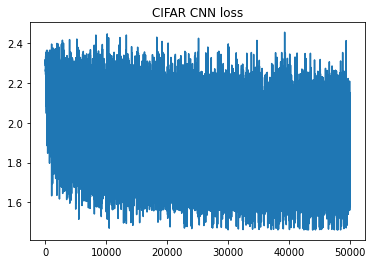

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("CIFAR CNN loss")
plt.show()